# Importações

In [9]:
import xml.etree.ElementTree as xet
from glob import glob
import pandas as pd
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import precision_score, recall_score
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
import random
import time

In [2]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15290944323545034022
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7604932448
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4201107436677027147
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


2024-04-08 16:24:19.835318: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-08 16:24:19.836051: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-04-08 16:24:19.836781: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-04-08 16:24:19.855635: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-08 16:24:19.855804: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 na

# Tratando Dataset

In [3]:
!curl -L -o /tmp/tcc_alpd/archive.tar.gz "https://www.dropbox.com/scl/fi/khnnv0x8pcpbzlgfevqac/archive.tar.gz?rlkey=55w3pkxp02szjpqw22df7hmn8&dl=0"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   256    0   256    0     0    260      0 --:--:-- --:--:-- --:--:--   260
100   491    0   491    0     0    185      0 --:--:--  0:00:02 --:--:--   449
100  202M  100  202M    0     0  14.1M      0  0:00:14  0:00:14 --:--:-- 19.8M


In [4]:
!tar xfv /tmp/tcc_alpd/archive.tar.gz -C /tmp/tcc_alpd

archive/
archive/.DS_Store
archive/images/
archive/annotations/
archive/annotations/Cars213.xml
archive/annotations/Cars207.xml
archive/annotations/Cars398.xml
archive/annotations/Cars367.xml
archive/annotations/Cars401.xml
archive/annotations/Cars415.xml
archive/annotations/Cars373.xml
archive/annotations/Cars429.xml
archive/annotations/Cars47.xml
archive/annotations/Cars53.xml
archive/annotations/Cars165.xml
archive/annotations/Cars171.xml
archive/annotations/Cars159.xml
archive/annotations/Cars84.xml
archive/annotations/Cars90.xml
archive/annotations/Cars91.xml
archive/annotations/Cars85.xml
archive/annotations/Cars158.xml
archive/annotations/Cars170.xml
archive/annotations/Cars164.xml
archive/annotations/Cars52.xml
archive/annotations/Cars46.xml
archive/annotations/Cars428.xml
archive/annotations/Cars414.xml
archive/annotations/Cars372.xml
archive/annotations/Cars366.xml
archive/annotations/Cars400.xml
archive/annotations/Cars399.xml
archive/annotations/Cars206.xml
archive/annotati

In [10]:
IMAGE_PATH="/tmp/tcc_alpd/archive/images/"
ANNOTATIONS_PATH = "/tmp/tcc_alpd/archive/annotations/"

In [3]:
def generate_dataframe_from_xml_annotations(directory):
    path = glob(directory)
    labels_dict = dict(filepath=[], xmin=[], xmax=[], ymin=[], ymax=[])
    
    for filename in path:
        info = xet.parse(filename)
        root = info.getroot()
        member_object = root.find('object')
        labels_info = member_object.find('bndbox')
        xmin = int(labels_info.find('xmin').text)
        xmax = int(labels_info.find('xmax').text)
        ymin = int(labels_info.find('ymin').text)
        ymax = int(labels_info.find('ymax').text)

        labels_dict['filepath'].append(filename)
        labels_dict['xmin'].append(xmin)
        labels_dict['xmax'].append(xmax)
        labels_dict['ymin'].append(ymin)
        labels_dict['ymax'].append(ymax)

    df = pd.DataFrame(labels_dict)
    return df

def getFilename(filepath):
    filename_image = xet.parse(filepath).getroot().find('filename').text
    filepath_image = os.path.join(IMAGE_PATH, filename_image)
    return filepath_image

def get_image_paths_from_dataframe(df):
    return df['filepath'].apply(getFilename)

In [4]:
df = generate_dataframe_from_xml_annotations(ANNOTATIONS_PATH+'*.xml')
image_path = get_image_paths_from_dataframe(df)
df

filepath  xmin  xmax  ymin  ymax
0    /tmp/tcc_alpd/archive/annotations/Cars400.xml   303   340   191   217
1    /tmp/tcc_alpd/archive/annotations/Cars104.xml   195   244   266   282
2    /tmp/tcc_alpd/archive/annotations/Cars224.xml   181   243   250   275
3    /tmp/tcc_alpd/archive/annotations/Cars311.xml   295   355   166   185
4    /tmp/tcc_alpd/archive/annotations/Cars319.xml   167   232   228   259
..                                             ...   ...   ...   ...   ...
428  /tmp/tcc_alpd/archive/annotations/Cars396.xml   181   269   264   289
429  /tmp/tcc_alpd/archive/annotations/Cars388.xml   149   255   130   158
430   /tmp/tcc_alpd/archive/annotations/Cars92.xml   281   393   185   271
431  /tmp/tcc_alpd/archive/annotations/Cars126.xml   103   293    99   201
432  /tmp/tcc_alpd/archive/annotations/Cars368.xml   173   223   173   203

[433 rows x 5 columns]

In [6]:
labels = df.iloc[:,1:].values
data = []
output = []
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape

    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0

    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax)

    data.append(norm_load_image_arr)
    output.append(label_norm)

In [7]:
def split_train_test_data(processed_data, processed_output, train_size=0.8, random_state=None):
    X = np.array(processed_data, dtype=np.float32)
    y = np.array(processed_output, dtype=np.float32)

    x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=random_state)

    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = split_train_test_data(data, output, train_size=0.8, random_state=0)
print("Tamanhos dos conjuntos de treino e teste:")
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Tamanhos dos conjuntos de treino e teste:
x_train shape: (346, 224, 224, 3)
x_test shape: (87, 224, 224, 3)
y_train shape: (346, 4)
y_test shape: (87, 4)


# Treinando Modelo

In [8]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)
model = Model(inputs=inception_resnet.input,outputs=headmodel)

2024-04-08 16:24:29.555172: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-04-08 16:24:29.555345: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-08 16:24:29.555491: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 computeCapability: 7.5
coreClock: 1.71GHz coreCount: 46 deviceMemorySize: 7.78GiB deviceMemoryBandwidth: 417.23GiB/s
2024-04-08 16:24:29.555525: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-04-08 16:24:29.555549: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-04-08 16:24:29.555564: I tensorflow/stream_executor/platform/

In [15]:
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [10]:
history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=50,
                    validation_data=(x_test,y_test))

2024-04-08 16:24:33.215675: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-04-08 16:24:33.216029: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2799925000 Hz


Epoch 1/50


2024-04-08 16:24:43.554923: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-04-08 16:24:43.761138: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


35/35 [==============================] - 20s 228ms/step - loss: 0.0522 - val_loss: 0.0338
Epoch 2/50
35/35 [==============================] - 5s 139ms/step - loss: 0.0152 - val_loss: 0.0214
Epoch 3/50
35/35 [==============================] - 5s 139ms/step - loss: 0.0098 - val_loss: 0.0166
Epoch 4/50
35/35 [==============================] - 5s 139ms/step - loss: 0.0065 - val_loss: 0.0144
Epoch 5/50
35/35 [==============================] - 5s 139ms/step - loss: 0.0041 - val_loss: 0.0126
Epoch 6/50
35/35 [==============================] - 5s 139ms/step - loss: 0.0037 - val_loss: 0.0107
Epoch 7/50
35/35 [==============================] - 5s 139ms/step - loss: 0.0032 - val_loss: 0.0119
Epoch 8/50
35/35 [==============================] - 5s 140ms/step - loss: 0.0034 - val_loss: 0.0105
Epoch 9/50
35/35 [==============================] - 5s 140ms/step - loss: 0.0031 - val_loss: 0.0103
Epoch 10/50
35/35 [==============================] - 5s 140ms/step - loss: 0.0020 - val_loss: 0.0120
Epoch 11/

In [ ]:
model.save('./license_plate_detection.h5')

# Validando Modelo

In [3]:
model = tf.keras.models.load_model('./license_plate_detection.h5')

2024-04-08 17:18:49.356796: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-04-08 17:18:49.357565: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-04-08 17:18:49.376592: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-08 17:18:49.376732: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 computeCapability: 7.5
coreClock: 1.71GHz coreCount: 46 deviceMemorySize: 7.78GiB deviceMemoryBandwidth: 417.23GiB/s
2024-04-08 17:18:49.376755: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-04-08 17:18:49.378297: I tensorflow/stream_executor/platform/def

In [11]:
y_pred = model.predict(x_test)

In [12]:
y_test_flat = np.argmax(y_test, axis=1)
y_pred_flat = np.argmax(y_pred, axis=1)

precision = precision_score(y_test_flat, y_pred_flat, average='macro')
recall = recall_score(y_test_flat, y_pred_flat, average='macro')

print("Precision:", precision)
print("Recall:", recall)

Precision: 0.8897306397306397
Recall: 0.8754054054054055


In [11]:
def object_detection(path):
    image = cv2.imread(path)
    h, w, d = image.shape
    
    image_arr_224 = img_to_array(load_img(path, target_size=(224, 224))) / 255.0  # Convert to array & normalized
    test_arr = image_arr_224.reshape(1, 224, 224, 3)
    
    coords = model.predict(test_arr)
    
    denorm = np.array([w, w, h, h])
    coords = coords * denorm
    coords = coords.astype(np.int32)
    
    xmin, xmax, ymin, ymax = coords[0]
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)
    
    return image

2024-04-08 17:28:10.471371: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-04-08 17:28:10.471674: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2799925000 Hz
2024-04-08 17:28:12.371308: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-04-08 17:28:12.491919: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


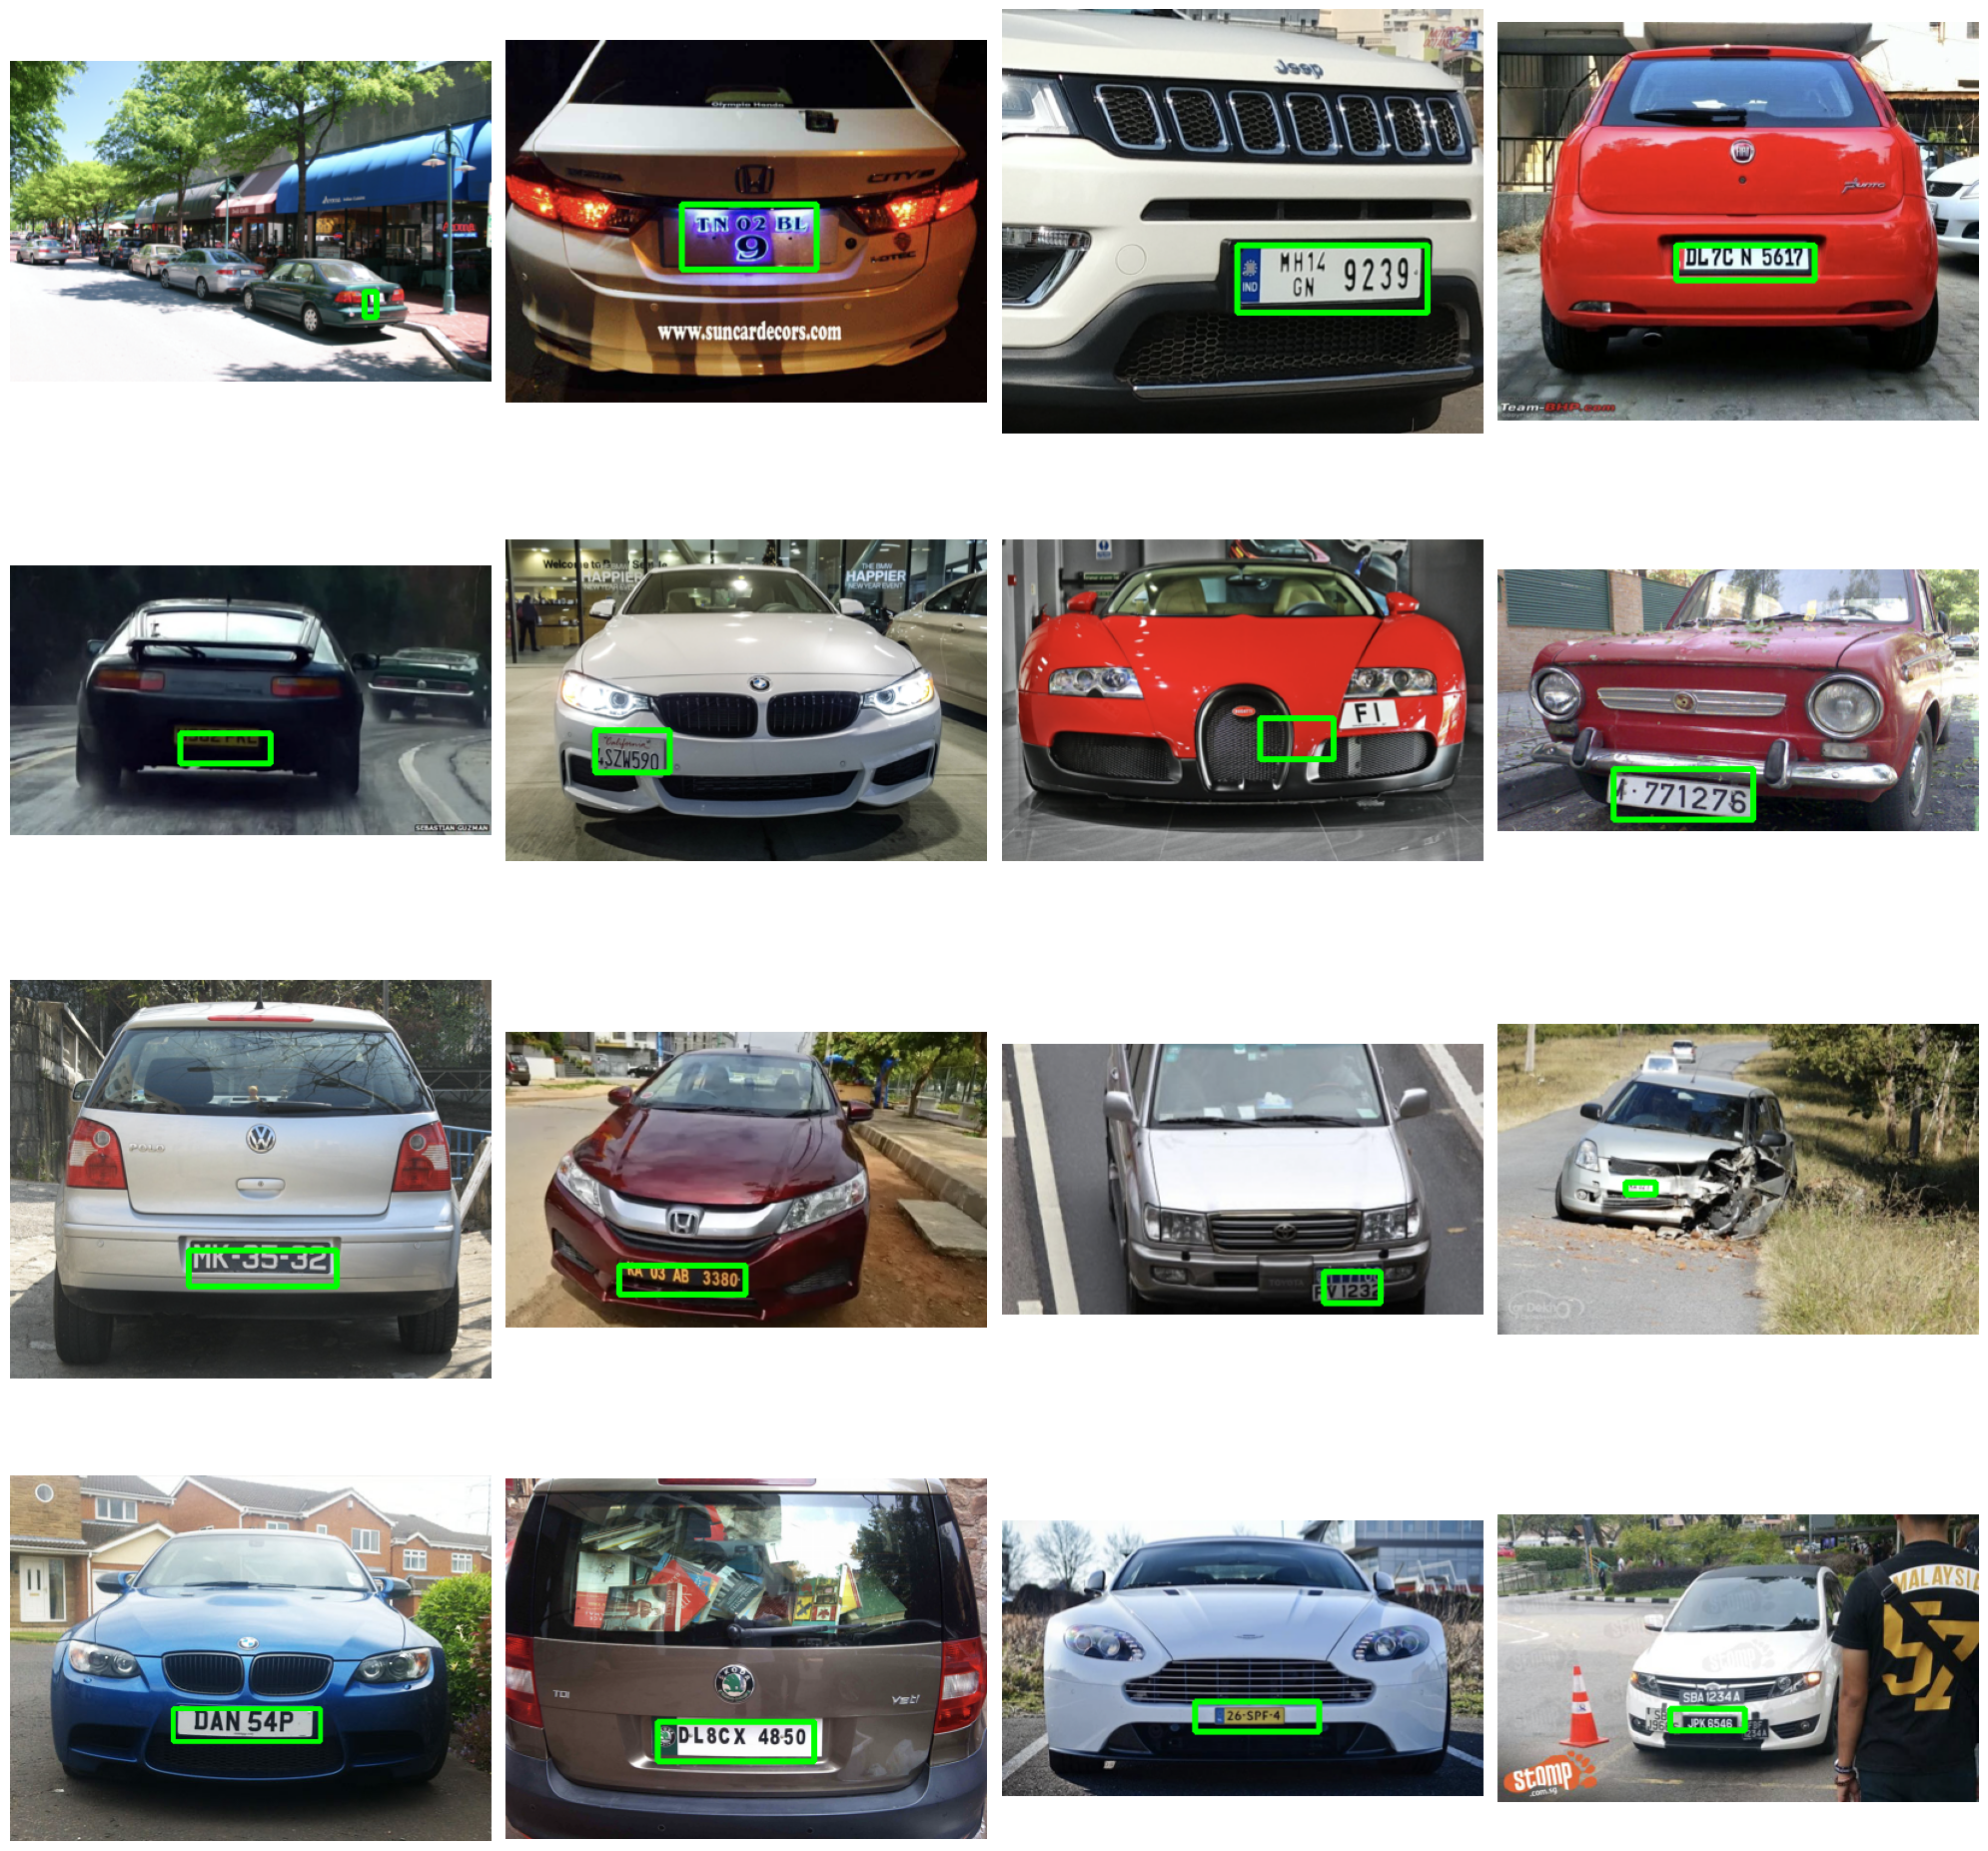

In [12]:
def plot_random_images(image_paths, num_images=16):
    selected_images = random.sample(image_paths, num_images)
    
    num_rows = num_images // 4
    fig, axs = plt.subplots(num_rows, 4, figsize=(20, 5 * num_rows))
    
    for i, image_path in enumerate(selected_images):
        row = i // 4
        col = i % 4
        
        image_with_box = object_detection(image_path)
        
        axs[row, col].imshow(cv2.cvtColor(image_with_box, cv2.COLOR_BGR2RGB))
        axs[row, col].axis('off')
        
    plt.tight_layout()
    plt.show()

image_paths = [os.path.join(IMAGE_PATH, filename) for filename in os.listdir(IMAGE_PATH)]

plot_random_images(image_paths, num_images=16)

In [13]:
def predict_time(image_paths, num_images=50):
    start_time = time.time()

    for path in random.sample(image_paths, num_images):
        image_arr_224 = img_to_array(load_img(path, target_size=(224, 224))) / 255.0
        test_arr = image_arr_224.reshape(1, 224, 224, 3)
        model.predict(test_arr)

    end_time = time.time()
    elapsed_time = end_time - start_time
    return elapsed_time

prediction_time = predict_time(image_paths)
print("Tempo total de predição para 50 imagens aleatórias: {:.2f} segundos".format(prediction_time))

Tempo total de predição para 50 imagens aleatórias: 2.45 segundos
